In [8]:
import os
os.environ["SPARK_HOME"] = "/home/software/spark-3.1.2-bin-hadoop3.2/"
os.environ["HADOOP_CONF_DIR"] = "/usr/local/hadoop/etc/hadoop/"
os.environ["PYSPARK_PYTHON"]= "python3.9"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3.9"

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


conf = SparkConf().setAll([('spark.app.name', 'Trabajo_taxis_3'), \
                               ('spark.executor.memory', '1g'), \
                               ('spark.executor.instances','20'), \
                               ('spark.executor.cores', '2'), \
                               ('spark.ui.port', '4677'), \
                               ('spark.driver.memory','1g')])
    
spark = SparkSession.builder.config(conf=conf).master('yarn').getOrCreate()#yarn es gestor de recursos. Nos da los nodos dentro del cluster

sc = spark.sparkContext

    # Datos de taxis
    #!/usr/local/hadoop/bin/hdfs dfs -put tripdata_2017-01.csv
df = spark.read.csv('tripdata_2017-01.csv', header=True, inferSchema=True)

    #Datos de la zona de taxis
    #!/usr/local/hadoop/bin/hdfs dfs -put taxi+_zone_lookup.csv  
df1 = spark.read.csv('taxi+_zone_lookup.csv', header=True, inferSchema=True)
    

Exception: Unable to find py4j in /home/software/spark-3.1.2-bin-hadoop3.2/python, your SPARK_HOME may not be configured correctly

In [3]:
pip install findspark

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



PROBLEMA 1: Tiempo de ejecución con un número creciente de cores.

In [ ]:
from time import time 
import numpy as np
import pyspark.sql.functions as F
        
t_0=time()  
    
# Aquí empieza el código del que se calculará el tiempo de ejecución-------------------------------------------------------------------------------------

df.select(
    
        (df['trip_distance']/0.621371 /
        (
            F.unix_timestamp(F.to_timestamp(df['tpep_dropoff_datetime']))/3600  - 
            F.unix_timestamp(F.to_timestamp(df['tpep_pickup_datetime']))/3600
        )
        ).alias('v(km/h)'),
    
    F.concat(F.hour(F.to_timestamp(df['tpep_dropoff_datetime'])),F.lit(':00')).alias('Hour'),
    
    
).groupby('Hour').mean('v(km/h)').orderBy('avg(v(km/h))',ascending=False).toPandas()   

print("El tiempo de ejecución es de",np.round(time()-t_0, 3), "segundos.")


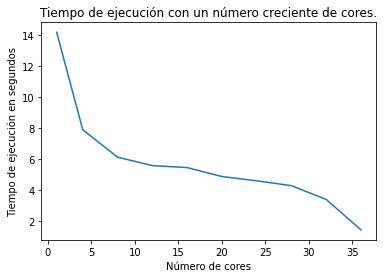

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# La tupla 'x' guarda los cores y la tupla 'y' el tiempo de ejecución correspondiente

x = [1,4,8,12,16,20,24,28,32,36]
y = [14.170,7.877,6.11,5.566,5.438,4.859,4.583,4.27,3.38,1.415]

plt.plot(x,y)
plt.xlabel('Número de cores')
plt.ylabel('Tiempo de ejecución en segundos')
plt.title('Tiempo de ejecución con un número creciente de cores.')
plt.show()


La mayor caída se produce al principio, cuando pasamos de un sistema con una sola máquina de un core a un sistema distribuido de dos máquinas con dos cores cada una. Una vez tenemos un sistema distribuido, el tiempo de ejecución sigue disminuyendo progresivamente a medida que se aumenta el número de cores. 

PROBLEMA 2: Velocidad de procesamiento.

In [67]:
t = sc.parallelize([14.170,7.877,6.11,5.566,5.438,4.859,4.583,4.27,3.38,1.415])
import pandas as pd

count = df.count()

y = t.map(lambda x : count/float(x))
list = y.collect()

vp = pd.DataFrame(np.round(list,3)).rename(columns={0:'Velocidad de procesamiento'}, index={0:1,1:4,2:8,3:12,4:16,5:20,6:24,7:28,8:32,9:36})
vp.index.name = 'Número de cores'
vp

#La velocidad de procesamiento representa el número de filas procesadas por segundo para el código del problema 1


,Velocidad de procesamiento
Número de cores,
1,68525.759
4,123271.550
8,158921.440
12,174453.827
16,178560.132
20,199837.415
24,211872.136
28,227402.810
32,287281.065


La velocidad de procesamiento aumenta con el número de cores.

PROBLEMA 3: Cálculo de aceleración para el caso anterior.

In [80]:
# Para el caso anterior, tomamos el tiempo con un core y calculamos la aceleración entre este proceso y el resto
to = 14.170
tm = sc.parallelize([7.877,6.11,5.566,5.438,4.859,4.583,4.27,3.38,1.415])

a = tm.map(lambda x : to/x)
lista = a.collect()

pda = pd.DataFrame(np.round(lista,3)).rename(columns={0:'Aceleración o speed-up'}, index={0:4,1:8,2:12,3:16,4:20,5:24,6:28,7:32,8:36})
pda.index.name = 'Número de cores'
pda


,Aceleración o speed-up
Número de cores,
4,1.799
8,2.319
12,2.546
16,2.606
20,2.916
24,3.092
28,3.319
32,4.192
36,10.014


El speed-up aumenta con el número de cores del proceso distribuido. Se observa un incremento del rendimiento muy significativo cuando se pasa de 1 core a 36.  

PROBLEMA 4: Cantidad de datos procesados.

In [83]:
# Para conocer la cantidad de datos procesados, hacemos un count sobre la tabla de la que se parte en el código del problema 1

print('La cantidad de datos procesados (filas) es de',df.count())

La cantidad de datos procesados (filas) es de 971010
